In [4]:

%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
import os

if ".." not in sys.path:
    sys.path.append("..")

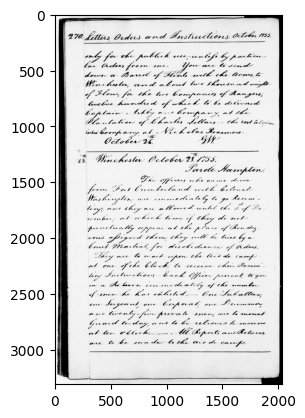

In [1]:
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

image = "2700270"
imagePath = f"./gw/pages/{image}.png"
gtPath = f"./gw/ground_truth/{image}.gtp"
hgtPath = f"./gw/heuristic_ground_truth/{image}.gtp"

imageFile = Image.open(imagePath)

# Für später folgende Verarbeitungsschritte muss das Bild mit float32-Werten vorliegen.
im_arr = np.asarray(imageFile)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(im_arr, cmap=cm.get_cmap('Greys_r'))


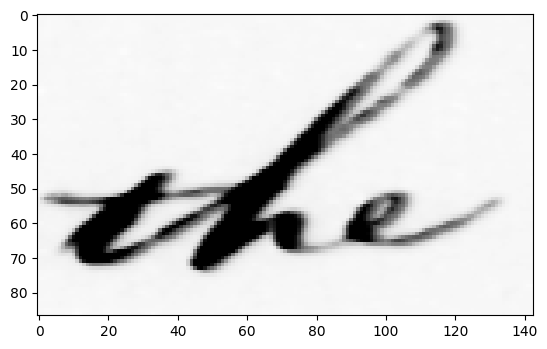

In [2]:
# load test image
labels = open(gtPath ,"r")
wordTheLine = labels.read().split("\n")[9].split(" ")
y1 , x1 , y2 , x2 = int(wordTheLine[0]) , int(wordTheLine[1]) , int(wordTheLine[2]) , int(wordTheLine[3])
testing_word_arr = im_arr[x1:x2, y1:y2]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(testing_word_arr, cmap=cm.get_cmap('Greys_r'))

In [8]:
# compute the features of the test image 
from scipy.cluster.vq import kmeans2
from common.features import compute_sift_descriptors

testing_word_frames ,testing_word_desc  = compute_sift_descriptors(testing_word_arr)
page_frames ,page_desc  = compute_sift_descriptors(im_arr)
n_centroids = 100 
# create a cluster of the full image
_, labels = kmeans2(page_desc, n_centroids, iter=20, minit='points')

print(len(page_frames))

16932


<BarContainer object of 100 artists>

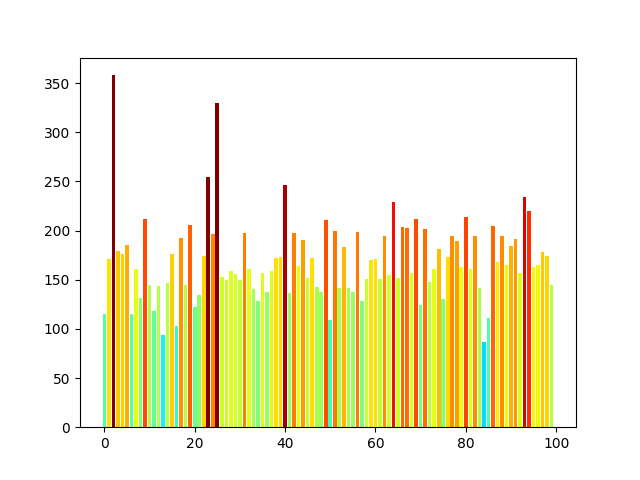

In [9]:
# compute the bag of features
bin_count = np.bincount(labels,minlength = n_centroids)
bin_count

fig = plt.figure()
ax = fig.add_subplot(111)
colormap = cm.get_cmap('jet')
ax.bar(list(range(n_centroids)) , bin_count , color = [colormap(bin) for bin in bin_count])

sift_descriptors shape (16932, 128)
page_frames shape 16932
labels shape (16932,)
x1=319, x2=580, y1=406, y2=723
histogram {21: 4, 31: 6, 29: 1, 51: 5, 34: 4, 22: 2, 67: 2, 45: 4, 91: 1, 71: 7, 63: 1, 74: 8, 64: 5, 42: 3, 93: 3, 17: 3, 66: 3, 37: 1, 43: 3, 30: 3, 86: 2, 87: 2, 8: 1, 7: 4, 2: 6, 32: 3, 79: 3, 33: 3, 83: 3, 82: 2, 3: 2, 28: 3, 57: 1, 90: 2, 78: 8, 54: 2, 9: 5, 59: 2, 26: 5, 80: 5, 55: 4, 47: 2, 41: 2, 46: 1, 4: 1, 14: 4, 68: 1, 75: 2, 52: 3, 77: 6, 96: 3, 97: 1, 44: 4, 98: 3, 39: 3, 72: 2, 12: 1, 38: 3, 27: 3, 25: 1, 18: 1, 35: 1, 23: 3, 95: 2, 81: 1, 49: 1, 94: 1, 15: 3, 11: 1, 36: 1, 58: 2, 92: 1, 73: 3, 76: 1, 6: 1, 84: 1, 85: 1}


<BarContainer object of 77 artists>

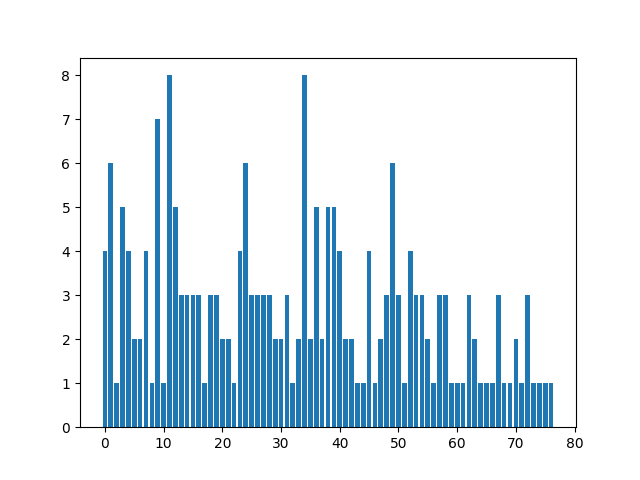

In [10]:
# takes a position of a grid in the image and uses the cluster of sift desc to calculate the bag of features histgramm
def get_bag_of_words_histogram(sift_descriptors , page_frames , labels , x1 , x2 , y1 , y2):
	# sift_descriptors: the sift descriptors of the full image
	# sift_descriptors_positions: the positions of the sift descriptors in the full image
	# sift_descriptors_labels_array: an array that contains a label for each sift descriptors
	# x1,x2,y1,y2: the positions of the frame

	# the function works as follows:
		# go over all descriptors inside the frame
		# for each one of them get its label
		# increment a counter for each label
		# return the histogram
		# the histogram is a map of this form {'label' : count} e.g {'f1' : 4} means that the label f1 is coming 4 times inside the frame
	assert sift_descriptors.shape[0] == len(page_frames) and len(page_frames) == labels.shape[0] , "wrong vars"
	print("sift_descriptors shape" , sift_descriptors.shape)
	print("page_frames shape" , len(page_frames))
	print("labels shape" , labels.shape)
	print(f"x1={x1}, x2={x2}, y1={y1}, y2={y2}")

	label_to_count = {}
	for desc , frame , label in zip(sift_descriptors , page_frames , labels):
		if frame[0] < x1 or frame[0] > x2 or frame[1] < y1 or frame[1]  > y2:
			continue
		label_to_count[label] = label_to_count.get(label , 0) + 1
	
	return label_to_count


request_image_histogram = get_bag_of_words_histogram(page_desc , page_frames , labels , x1 , y1 , x2 , y2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(range(len(request_image_histogram)), list(request_image_histogram.values()), align='center')
